# Preliminary Set-up

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%pwd

'/content'

In [3]:
%cd drive/MyDrive/QLI_Lab_Project/video_processing

/content/drive/MyDrive/QLI_Lab_Project/video_processing


In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import pandas as pd

root = Path("./")
videos_path = root / "Videos"
str(videos_path)

'Videos'

# Fisher Info

In [40]:
x_min = 320 # min x coordinate
x_max = 1400 # max x coordinate
y_min = 90 # min y coordinate
y_max = 250 # max y coordinate
def get_hists(vid_path, time=60):
    """
    Returns and saves an np array with shape (24 * 60, 1080) where each row contains the
    scattered light intensities for the beam at a given frame
    """
    theta = int(vid_path.stem)
    cap = cv2.VideoCapture(str(vid_path))
    success,image = cap.read()
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    frame_num = 0
    start_frame_num = 0
    hists = []
    while success and ((frame_num - start_frame_num) / fps) < time:
        start_frame_num = (cap.get(cv2.CAP_PROP_FRAME_COUNT) - fps * 61)
        if frame_num >= start_frame_num:
            pixel_positions = np.load(f'beam_pixel_positions_npys/{theta}.npy')
            x_pixel_positions = pixel_positions[0]
            y_pixel_positions = pixel_positions[1]
            light_intensities = np.sum(image[y_min:y_max, x_min:x_max][[y_pixel_positions, x_pixel_positions]], axis=1)
            hists.append(light_intensities)
        success,image = cap.read()
        frame_num += 1
    hists_as_np = np.array(hists)
    np.save(f'hists/theta_{theta}_hists.npy', hists_as_np)
    return hists_as_np

In [41]:
# get a histogram for each pixel on a beam in a video
theta = 0
hists = get_hists(videos_path / f'{theta}.MOV')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


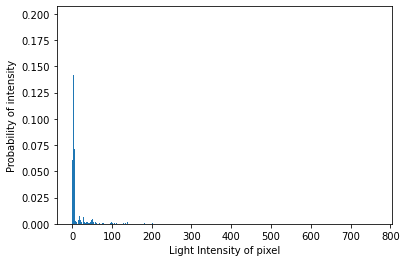

1.0


In [56]:
# display a pdf (probability density function) for a pixel of a beam in a video
theta = 130
hists = np.load(f'hists/theta_{theta}_hists.npy')
n, bins, _ = plt.hist(hists[:, 1], bins=range(766), width=1, density=True) # display pdf of the leftmost pixel of a beam
plt.xlabel("Light Intensity of pixel")
plt.ylabel("Probability of intensity")
plt.show()
print(np.sum(n*np.diff(bins))) # calculate integral for pdf

In [46]:
for vid_path in sorted(videos_path.glob("*")):
    print(vid_path)
    theta = int(vid_path.stem)
    print(theta)
    get_hists(vid_path)

Videos/0.MOV
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Videos/10.MOV
10
Videos/120.MOV
120
Videos/130.MOV
130
Videos/140.MOV
140
Videos/150.MOV
150
Videos/160.MOV
160
Videos/170.MOV
170
Videos/175.MOV
175
Videos/176.MOV
176
Videos/177.MOV
177
Videos/178.mov
178
Videos/179.MOV
179
Videos/20.MOV
20
Videos/30.MOV
30
Videos/40.MOV
40
Videos/50.MOV
50


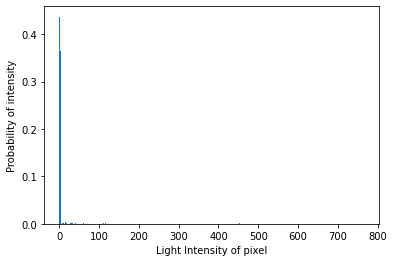

0.9999999999999999


In [57]:
# display a pdf (probability density function) for a pixel of a beam in a video
theta = 150
hists = np.load(f'hists/theta_{theta}_hists.npy')
n, bins, _ = plt.hist(hists[:, 1], bins=range(766), width=1, density=True) # display pdf of the leftmost pixel of a beam
plt.xlabel("Light Intensity of pixel")
plt.ylabel("Probability of intensity")
plt.show()
print(np.sum(n*np.diff(bins))) # calculate integral for pdf

# Save pdf as p(x)

In [103]:
def get_pdfs(theta):
    """
    Parameters:
        - hists: nd.array (1440, 1080)
    Returns:
        - Saves and returns pdfs in form of numpy array - Shape (765, 1080)
        - Each element contains the probability of a light intensity (ranging from 0-765) at pixel position # column number.
    """
    hists = np.load(f'hists/theta_{theta}_hists.npy')
    pdf = np.zeros((765, 1080))
    for col in range(hists.shape[1]):
        unique_values, counts = np.unique(hists[:, col], return_counts=True)
        pdf[unique_values.astype(int), col] = counts / hists.shape[1]
        # print(unique_values.shape)
        # print("___")
        # print(counts)
    np.save(f'pdfs/theta_{theta}_pdfs.npy', pdf)
    return pdf

In [96]:
# get pdf for a video
theta = 0
pdf = get_pdfs(theta)

Text(0, 0.5, 'Probability of intensity')

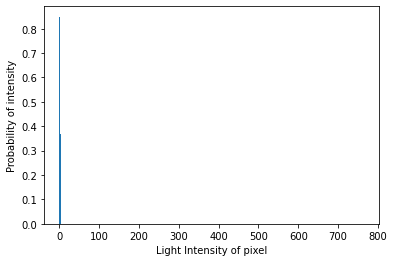

In [112]:
# display a pdf (probability density function) for a pixel of a beam in a video
plt.bar(np.arange(0, 765), pdf[:, 0])
plt.xlabel("Light Intensity of pixel")
plt.ylabel("Probability of intensity")

In [104]:
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
for theta in thetas:
    get_pdfs(theta)

Text(0, 0.5, 'Probability of intensity')

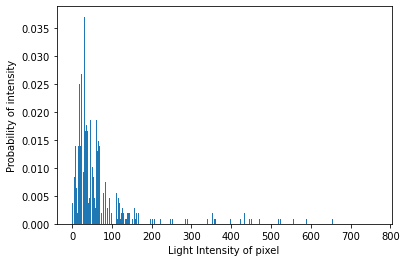

In [113]:
# display a pdf (probability density function) for a pixel of a beam in a video
theta = 120
pdf = np.load(f'pdfs/theta_{theta}_pdfs.npy')
plt.bar(np.arange(0, 765), pdf[:, 8])
plt.xlabel("Light Intensity of pixel")
plt.ylabel("Probability of intensity")

# Calculate the Fisher Information for theta = 0º

In [108]:
theta = 0
pdfs_0 = pdf = np.load(f'pdfs/theta_{theta}_pdfs.npy').astype(float)
theta = 10
pdfs_10 = pdf = np.load(f'pdfs/theta_{theta}_pdfs.npy').astype(float)
pdfs_0[pdfs_0 == 0] = 10**(-10)
pdfs_10[pdfs_10 == 0] = 10**(-10)

derivative = (np.log(pdfs_10) - np.log(pdfs_0)) / 10
integrand = (derivative) ** 2 * pdfs_0
integrals = np.trapz(integrand, dx=1, axis=0) # list of integrals 
# aka fisher information for each pixel on a beam, shape (1, 1080)
integrals.shape

(1080,)

Text(0, 0.5, 'Fisher Information')

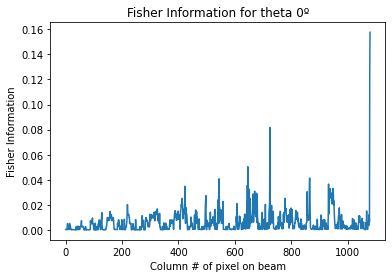

In [115]:
plt.plot(integrals)
plt.title("Fisher Information for theta 0º")
plt.xlabel("Column # of pixel on beam")
plt.ylabel("Fisher Information")

# Calculate all Fisher Infos

In [118]:
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
def get_FI(theta, lower_theta, upper_theta):
    """
    Parameters:
        - theta
        - lower_theta: the nearest angle less than theta that will be used for calculating the derivative of the pdfs at theta
        - upper_theta: the nearest angle greater than theta that will be used for calculating the derivative of the pdfs at theta
    Return and save the Fisher Info for a given theta
    """
    pdfs_0 = pdf = np.load(f'pdfs/theta_{lower_theta}_pdfs.npy').astype(float)
    pdfs_1 = pdf = np.load(f'pdfs/theta_{upper_theta}_pdfs.npy').astype(float)
    pdfs_2 = pdf = np.load(f'pdfs/theta_{theta}_pdfs.npy').astype(float)
    pdfs_0[pdfs_0 == 0] = 10**(-10)
    pdfs_1[pdfs_1 == 0] = 10**(-10)

    derivative = (np.log(pdfs_1) - np.log(pdfs_0)) / (upper_theta - lower_theta)
    integrand = (derivative) ** 2 * pdfs_2
    integrals = np.trapz(integrand, dx=1, axis=0) # list of integrals 
    # aka fisher information for each pixel on a beam, shape (1, 1080)
    np.save(f'fisher_informations/theta_{theta}_FIs.npy', integrals)
    return integrals

In [119]:
FI = get_FI(0, 0, 10)

Text(0, 0.5, 'Fisher Information')

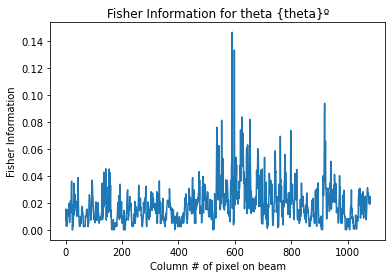

In [128]:
theta = 50
FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
plt.plot(FI)
plt.title('Fisher Information for theta {theta}º')
plt.xlabel("Column # of pixel on beam")
plt.ylabel("Fisher Information")

In [ ]:
for theta in range(10, 41, 10):
    print(theta)
    get_FI(theta, theta - 10, theta + 10)

In [127]:
get_FI(50, 40, 50)

array([0.00735464, 0.0155067 , 0.00288121, ..., 0.01934158, 0.02488969,
       0.01939215])

In [129]:
get_FI(120, 120, 130)

array([1.204898  , 1.3231836 , 1.37831502, ..., 0.44693121, 0.48274591,
       0.53776207])

In [131]:
for theta in range(130, 161, 10):
    print(theta)
    get_FI(theta, theta - 10, theta + 10)

130
140
150
160


In [133]:
get_FI(170, 160, 175)

array([0.00335174, 0.00040622, 0.0007051 , ..., 0.00666656, 0.00049635,
       0.01737122])

In [ ]:
get_FI(170, 160, 175)

In [134]:
get_FI(175, 175, 176)

array([1.73128275e+01, 5.87718848e+00, 2.69162467e-01, ...,
       2.40443985e-02, 2.78803741e-02, 3.69701112e-03])

In [135]:
for theta in range(176, 179):
    print(theta)
    get_FI(theta, theta - 1, theta + 1)

176
177
178


In [136]:
get_FI(179, 178, 0)

array([3.69910529e-07, 4.14184689e-07, 7.79199698e-07, ...,
       2.52668218e-06, 2.21015740e-05, 8.34433193e-06])

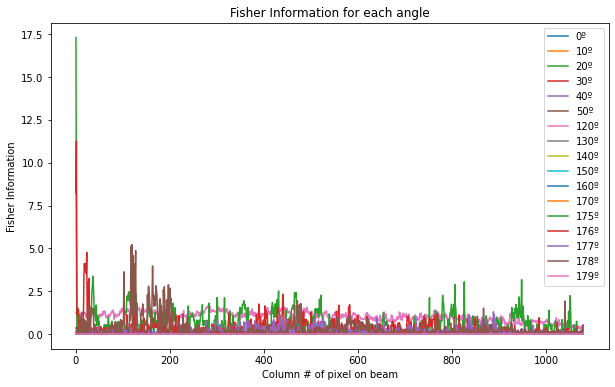

In [151]:
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for theta in thetas:
    FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
    plt.plot(FI, label=f'{theta}º')
ax.set_title('Fisher Information for each angle')
ax.set_xlabel("Column # of pixel on beam")
ax.set_ylabel("Fisher Information")
plt.legend()
plt.show()

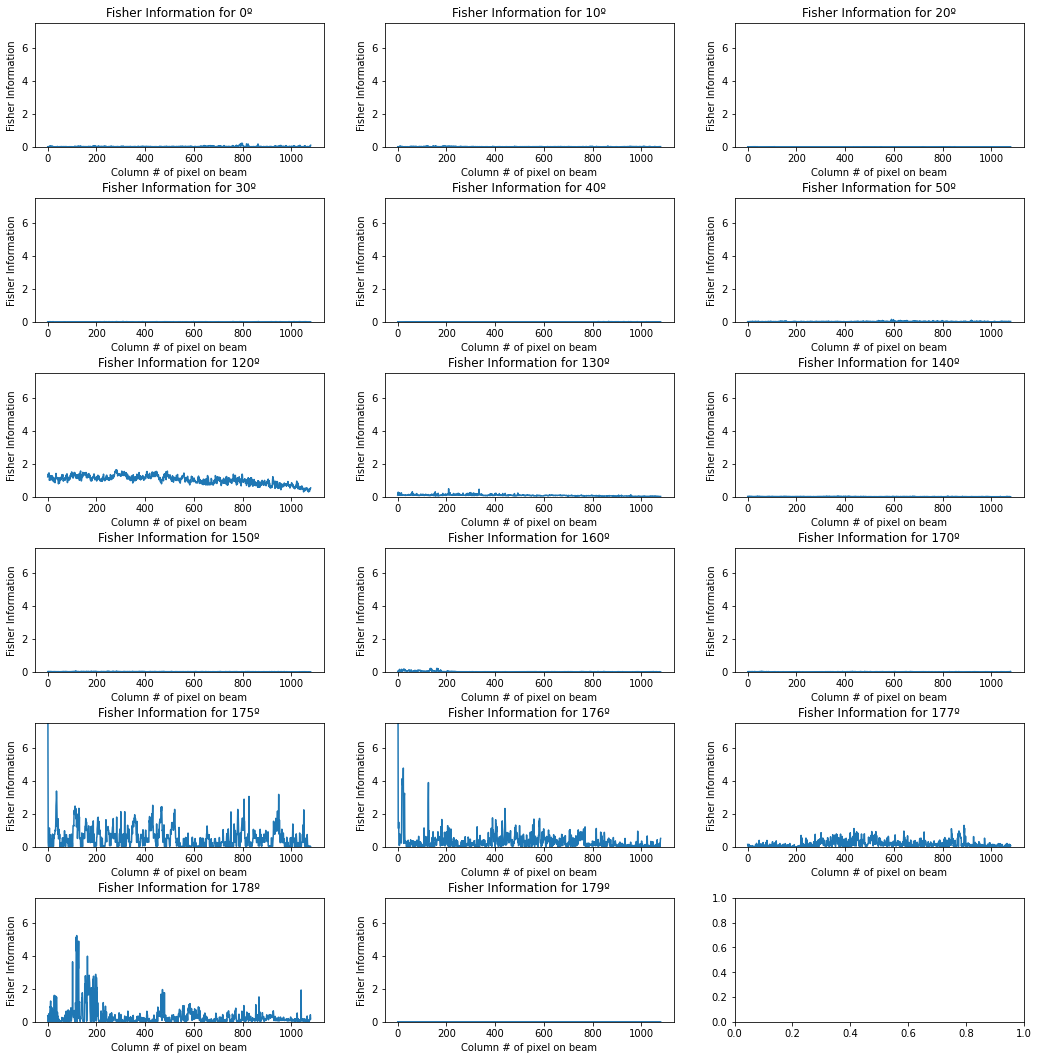

In [159]:
# Compare with simulations
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
fig.tight_layout(pad=3)
idx = 0
theta = thetas[idx]
for i in range(0, 6):
    for j in range(0, 3):
        if idx < len(thetas):
            theta = thetas[idx]
            FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
            ax[i][j].plot(FI, label=f'{theta}º')
            ax[i][j].set_ylim(0, 7.5)
            ax[i][j].set_title(f'Fisher Information for {theta}º')
            ax[i][j].set_xlabel("Column # of pixel on beam")
            ax[i][j].set_ylabel("Fisher Information")
        idx += 1
# plt.savefig("fisher_informations_diff_scales") # save plot as .png file
plt.savefig("fisher_informations_graphs/fisher_informations") # save plot as .png file
plt.show()

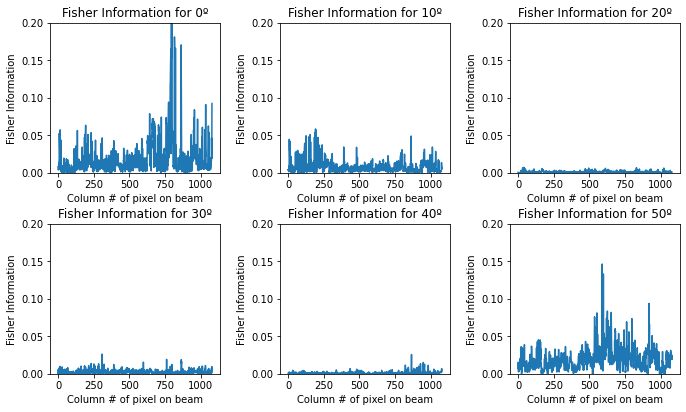

In [163]:
thetas = [0, 10, 20, 30, 40, 50]
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=3)
idx = 0
theta = thetas[idx]
for i in range(0, 2):
    for j in range(0, 3):
        if idx < len(thetas):
            theta = thetas[idx]
            FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
            ax[i][j].plot(FI, label=f'{theta}º')
            ax[i][j].set_ylim(0, 0.2)
            ax[i][j].set_title(f'Fisher Information for {theta}º')
            ax[i][j].set_xlabel("Column # of pixel on beam")
            ax[i][j].set_ylabel("Fisher Information")
        idx += 1
plt.savefig("fisher_informations_graphs/fisher_informations_0_to_50") # save plot as .png file
plt.show()

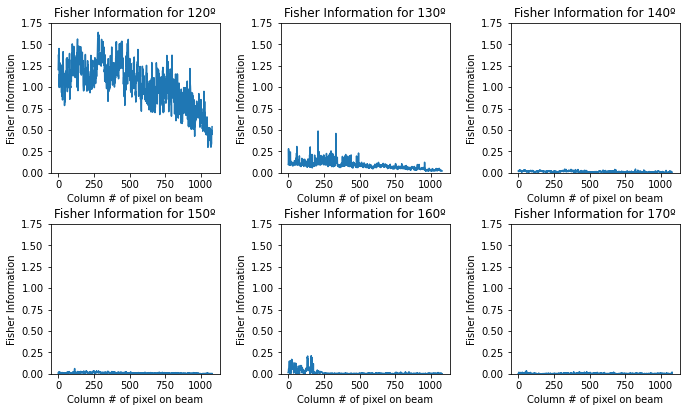

In [166]:
thetas = [120, 130, 140, 150, 160, 170]
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=3)
idx = 0
theta = thetas[idx]
for i in range(0, 2):
    for j in range(0, 3):
        if idx < len(thetas):
            theta = thetas[idx]
            FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
            ax[i][j].plot(FI, label=f'{theta}º')
            ax[i][j].set_ylim(0, 1.75)
            ax[i][j].set_title(f'Fisher Information for {theta}º')
            ax[i][j].set_xlabel("Column # of pixel on beam")
            ax[i][j].set_ylabel("Fisher Information")
        idx += 1
plt.savefig("fisher_informations_graphs/fisher_informations_120_to_170") # save plot as .png file
plt.show()

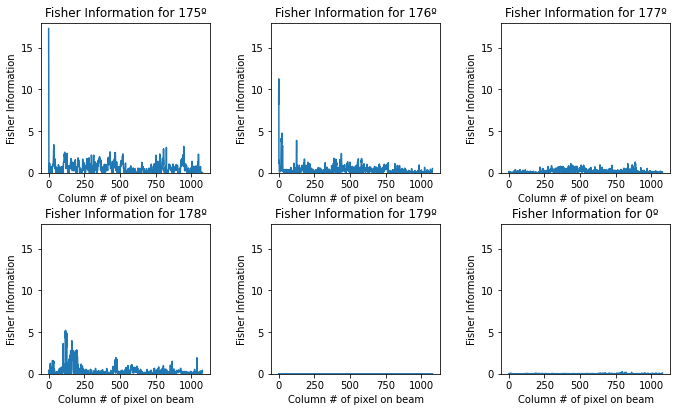

In [170]:
thetas = [175, 176, 177, 178, 179, 0]
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=3)
idx = 0
theta = thetas[idx]
for i in range(0, 2):
    for j in range(0, 3):
        if idx < len(thetas):
            theta = thetas[idx]
            FI = np.load(f'fisher_informations/theta_{theta}_FIs.npy')
            ax[i][j].plot(FI, label=f'{theta}º')
            ax[i][j].set_ylim(0, 18)
            ax[i][j].set_title(f'Fisher Information for {theta}º')
            ax[i][j].set_xlabel("Column # of pixel on beam")
            ax[i][j].set_ylabel("Fisher Information")
        idx += 1
plt.savefig("fisher_informations_graphs/fisher_informations_175_to_180") # save plot as .png file
plt.show()